In [1]:
import xarray as xr 
import glob 
import matplotlib.pyplot as plt
from scipy.signal import detrend

import numpy as np
import copy
import os 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle

import cartopy.crs as ccrs

from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from scipy.optimize import linear_sum_assignment
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

from eofs.xarray import Eof
from typing import Dict

import glob

import numpy as np
import os
import logging
import yaml
from dask.distributed import Client, get_client
import time
from datetime import timedelta

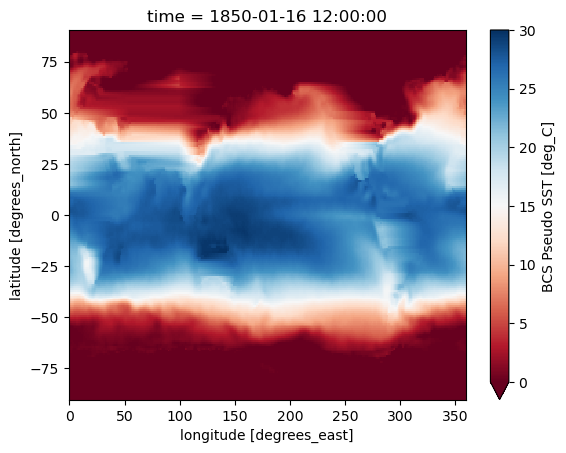

In [24]:
DSx = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/atm/cam/sst/sst_HadOIBl_bc_0.9x1.25_1850_2022_c241003.nc')
DSx['SST_cpl'].isel(time=0).plot(vmin=0, vmax=30, cmap='RdBu')

In [7]:
import xarray as xr
import pandas as pd
import numpy as np

def interpolate_temporal_frequency(ds, target_freq='6H'):
    """
    Interpolate an xarray Dataset from monthly to a higher temporal frequency.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Input dataset with monthly temporal resolution
    target_freq : str, default='6H'
        Target frequency for interpolation (e.g., '6H' for 6-hourly)
        
    Returns:
    --------
    xarray.Dataset
        Interpolated dataset with the target temporal frequency
    """
    # Ensure the input dataset has a datetime index
    if not isinstance(ds.time.values[0], np.datetime64):
        ds['time'] = pd.to_datetime(ds.time.values)
    
    # Create new time index at target frequency
    start_time = ds.time.values[0]
    end_time = ds.time.values[-1]
    new_time = pd.date_range(start=start_time, end=end_time, freq=target_freq)
    
    # Perform interpolation
    ds_interp = ds.interp(time=new_time, method='linear')
    
    # Add metadata about interpolation
    ds_interp.attrs['interpolation_info'] = f'Temporally interpolated from monthly to {target_freq} frequency'
    ds_interp.attrs['original_frequency'] = 'monthly'
    ds_interp.attrs['target_frequency'] = target_freq
    
    return ds_interp

def validate_interpolation(ds_original, ds_interpolated):
    """
    Validate the interpolation by comparing original and interpolated datasets
    at matching timestamps.
    
    Parameters:
    -----------
    ds_original : xarray.Dataset
        Original monthly dataset
    ds_interpolated : xarray.Dataset
        Interpolated dataset
        
    Returns:
    --------
    dict
        Dictionary containing validation metrics
    """
    # Find matching timestamps
    common_times = np.intersect1d(ds_original.time.values, 
                                 ds_interpolated.time.values)
    
    if len(common_times) == 0:
        raise ValueError("No matching timestamps found between datasets")
    
    # Compare values at matching timestamps
    original_subset = ds_original.sel(time=common_times)
    interpolated_subset = ds_interpolated.sel(time=common_times)
    
    # Calculate validation metrics for each variable
    metrics = {}
    for var in ds_original.data_vars:
        diff = original_subset[var] - interpolated_subset[var]
        metrics[var] = {
            'max_abs_error': float(abs(diff).max()),
            'mean_abs_error': float(abs(diff).mean()),
            'rmse': float(np.sqrt((diff ** 2).mean()))
        }
    
    return metrics

# Example usage:
"""
# Interpolate the dataset
ds_interpolated = interpolate_temporal_frequency(DSx, target_freq='6H')

# Validate the interpolation
validation_metrics = validate_interpolation(DSx, ds_interpolated)

# Print some basic information
print(f"Original time steps: {len(DSx.time)}")
print(f"Interpolated time steps: {len(ds_interpolated.time)}")
print("\nValidation metrics:")
for var, metrics in validation_metrics.items():
    print(f"\nVariable: {var}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

"""

'\n# Interpolate the dataset\nds_interpolated = interpolate_temporal_frequency(DSx, target_freq=\'6H\')\n\n# Validate the interpolation\nvalidation_metrics = validate_interpolation(DSx, ds_interpolated)\n\n# Print some basic information\nprint(f"Original time steps: {len(DSx.time)}")\nprint(f"Interpolated time steps: {len(ds_interpolated.time)}")\nprint("\nValidation metrics:")\nfor var, metrics in validation_metrics.items():\n    print(f"\nVariable: {var}")\n    for metric, value in metrics.items():\n        print(f"{metric}: {value}")\n\n'

In [19]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime

def convert_noleap_to_datetime(ds):
    """
    Convert cftime.DatetimeNoLeap timestamps to regular datetime objects in an xarray Dataset.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Input dataset with cftime.DatetimeNoLeap time coordinates
        
    Returns:
    --------
    xarray.Dataset
        Dataset with regular datetime time coordinates
    """
    # Create a list of regular datetime objects
    new_times = []
    for t in ds.time.values:
        # Extract components from cftime object
        new_times.append(datetime(
            year=t.year,
            month=t.month,
            day=1,
            hour=0,
            minute=0,
            second=0
        ))
    
    # Create new dataset with converted times
    ds_new = ds.copy()
    ds_new['time'] = new_times
    
    # Add metadata about conversion
    ds_new.time.attrs['calendar'] = 'proleptic_gregorian'
    ds_new.time.attrs['converted_from'] = 'noleap'
    
    return ds_new

def validate_conversion(times_before, times_after):
    """
    Validate that the time conversion maintained the correct temporal relationships.
    
    Parameters:
    -----------
    times_before : array-like
        Original cftime.DatetimeNoLeap times
    times_after : array-like
        Converted datetime times
        
    Returns:
    --------
    dict
        Dictionary containing validation results
    """
    validation = {
        'same_length': len(times_before) == len(times_after),
        'time_diffs_maintained': True,
        'year_matches': True,
        'month_matches': True,
        'day_matches': True,
        'hour_matches': True
    }
    
    for i in range(len(times_before)):
        t1 = times_before[i]
        t2 = times_after[i]
        
        validation['year_matches'] &= t1.year == t2.year
        validation['month_matches'] &= t1.month == t2.month
        validation['day_matches'] &= t1.day == t2.day
        validation['hour_matches'] &= t1.hour == t2.hour
        
        if i > 0:
            diff1 = times_before[i] - times_before[i-1]
            diff2 = times_after[i] - times_after[i-1]
            validation['time_diffs_maintained'] &= abs(diff2.total_seconds() - 
                                                     diff1.total_seconds()) < 1
    
    return validation

# Example usage:
"""
# Convert the dataset
ds_converted = convert_noleap_to_datetime(ds)

# Validate the conversion
validation_results = validate_conversion(ds.time.values, ds_converted.time.values)

# Print validation results
for check, result in validation_results.items():
    print(f"{check}: {result}")
"""

'\n# Convert the dataset\nds_converted = convert_noleap_to_datetime(ds)\n\n# Validate the conversion\nvalidation_results = validate_conversion(ds.time.values, ds_converted.time.values)\n\n# Print validation results\nfor check, result in validation_results.items():\n    print(f"{check}: {result}")\n'

## Interpolate

In [34]:
DSx = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/atm/cam/sst/sst_HadOIBl_bc_0.9x1.25_1850_2022_c241003.nc')
DSx = convert_noleap_to_datetime(DSx)
ds_interpolated = interpolate_temporal_frequency((DSx), target_freq='6h')

/glade/derecho/scratch/wchapman/tmp/ipykernel_14697/3087062740.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  new_time = pd.date_range(start=start_time, end=end_time, freq=target_freq)


## Save Interpolated

In [53]:
ds_interpolated.time.attrs.pop('calendar', None)
ds_interpolated[['SST_cpl','ice_cov']].to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/SST_forcing_1850-2022.nc')

In [73]:
DS =xr.open_dataset('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/SST/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.SST.185001-185912.nc')

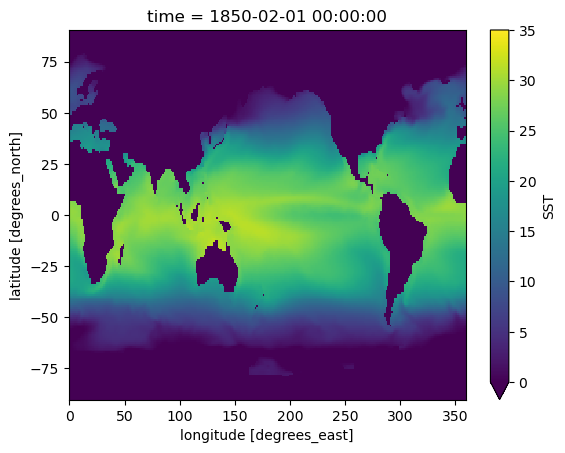

In [79]:
(DS['SST']-273.1).isel(time=0).plot(vmin=0,vmax=35)

## Climate runs? 

In [180]:
DS4k = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/atm/cam/sst/sst_HadOIBl_bc_0.9x1.25_2000climo_SST+4K_c180601.nc')['SST_cpl']
DS2k = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/atm/cam/sst/sst_HadOIBl_bc_0.9x1.25_2000climo_SST+2K_c180601.nc')['SST_cpl']
DSk = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/atm/cam/sst/sst_HadOIBl_bc_0.9x1.25_2000climo_c180511.nc')['SST_cpl']

DS4k['time'] = pd.date_range(start='2000-01-01', end='2000-12-01', freq='1MS')
DS4k_end = DS4k.isel(time=0)
DS4k_end['time'] = pd.date_range(start='2001-01-01', end='2002-12-01', freq='1MS')[0]
DS4k = xr.concat([DS4k, DS4k_end], dim='time')

DS2k['time'] = pd.date_range(start='2000-01-01', end='2000-12-01', freq='1MS')
DS2k_end = DS2k.isel(time=0)
DS2k_end['time'] = pd.date_range(start='2001-01-01', end='2002-12-01', freq='1MS')[0]
DS2k = xr.concat([DS2k, DS2k_end], dim='time')

DSk['time'] = pd.date_range(start='2000-01-01', end='2000-12-01', freq='1MS')
DSk_end = DSk.isel(time=0)
DSk_end['time'] = pd.date_range(start='2001-01-01', end='2002-12-01', freq='1MS')[0]
DSk = xr.concat([DSk, DSk_end], dim='time')

## Make from CAM run

In [2]:
# Get the current client if one exists and close it
try:
    client = get_client()
    client.close()
except ValueError:
    print("No active client found.")

client = Client()
print(f"Dask dashboard available at: {client.dashboard_link}")
time.sleep(19)  # Sleeps for 1 second

No active client found.
Dask dashboard available at: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/diehard/proxy/8787/status


2025-01-30 06:20:41,666 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:34111' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-open_dataset-SST-1be1123ff1188d555e20dfb8a2534d19', 'original-open_dataset-SST-9dc90291255fac314497f5612435ccc2', 'original-open_dataset-SST-94d56082c0b80f18af84e7e4f970b46c', 'original-open_dataset-SST-ab36510f083cf487bd1ecc36e1b5fd5f', 'original-open_dataset-SST-1939828b72435acdc584a1814e8bae06'} (stimulus_id='handle-worker-cleanup-1738243241.66578')
2025-01-30 06:20:41,680 - distributed.nanny - WARNING - Restarting worker
2025-01-30 06:20:42,126 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:33615' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-open_dataset-SST-b2d3e49ed42b43e001397bd08f17f204', 'original-open_dataset-SST-4af1593ba3ff88997ea78717c00385c6', 'original-open_dataset-SST-9dabfe4783ce6004c51e6813f89b2a

In [37]:
base_dir = '/glade/derecho/scratch/wchapman/archive/'

FNS = sorted(glob.glob(f'{base_dir}/f.e21.CREDIT_climate_F2000_4k/atm/hist/*h1*.nc'))

DS = xr.open_mfdataset(FNS, parallel=True)
DS = DS.isel(time=slice(0,-1))

DS1980 = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.1980.statics_1.0deg_F32.nc')
DS1980['SST'][:] = DS['SST'].values
DS1980.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.CLIM2000_4K.statics_1.0deg_F32.nc')

In [47]:
DS1 = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.CLIM2000.statics_1.0deg_F32.nc')
DS2 = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.CLIM2000_2K.statics_1.0deg_F32.nc')
DS3 = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.CLIM2000_4K.statics_1.0deg_F32.nc')

In [58]:
DS3 = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/climo_2000_2K//1980-01-01T00Z/1D/averaged_SingleLevel_1980-01_1D.nc')

In [1]:
DS1=xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.CLIM2000_2K.statics_1.0deg_F32.nc')
DS2=xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.CLIM2000_4K.statics_1.0deg_F32.nc')
DS3=xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.CLIM2000.statics_1.0deg_F32.nc')
DS4=xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.statics_1.0deg_F32.nc')

NameError: name 'xr' is not defined

In [2]:
ls -lathr /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst*

-rw-r-----+ 1 wchapman naml0001  22G Dec 19 02:33 /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.statics_1.0deg_F32.nc
-rw-r-----+ 1 wchapman naml0001 617M Jan 26 15:07 /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.1979.statics_1.0deg_F32.nc
-rw-r-----+ 1 wchapman naml0001 617M Jan 26 15:07 /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.1980.statics_1.0deg_F32.nc
-rw-r-----+ 1 wchapman naml0001 617M Jan 30 06:18 /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.CLIM2000.statics_1.0deg_F32.nc
-rw-r-----+ 1 wchapman naml0001 617M Jan 30 06:20 /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.CLIM2000_2K.statics_1.0deg_F32.nc
-rw-r-----+ 1 wchapman naml0001 617M Jan 30 06:21 /glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.climaterun.sst.CLIM2000_4K.statics_1.0deg_F32.nc
